In [1]:
import pandas as pd 
import feather 
import matplotlib.pyplot as plt
import seaborn as sns
import os
import pymc3 as pm
import numpy as np
from IPython.display import display

WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [3]:
game_result = feather.read_dataframe('../bin/game_result.feather')
game_result['p1_worst'] = 0
game_result['p2_worst'] = 0 
game_result['p3_worst'] = 0

game_result['worst_player'] = game_result['rank_3'].map({
    0: 'player1',
    1: 'player2',
    2: 'player3'
})
    
game_result['parity'] = game_result['parity'].map({
    'oee': 'fair_game',
    'eeo': 'unfair_game',
})
game_result = game_result.rename(columns={'parity': 'game'})

def func(row):
    worst_player = row['rank_3'] + 1
    row['p{}_worst'.format(str(worst_player))] = 1
    return row

game_result = game_result.apply(func, axis=1)
fair_game_result = game_result[game_result['game'] == 'fair_game']
unfair_game_result = game_result[game_result['game'] == 'unfair_game']

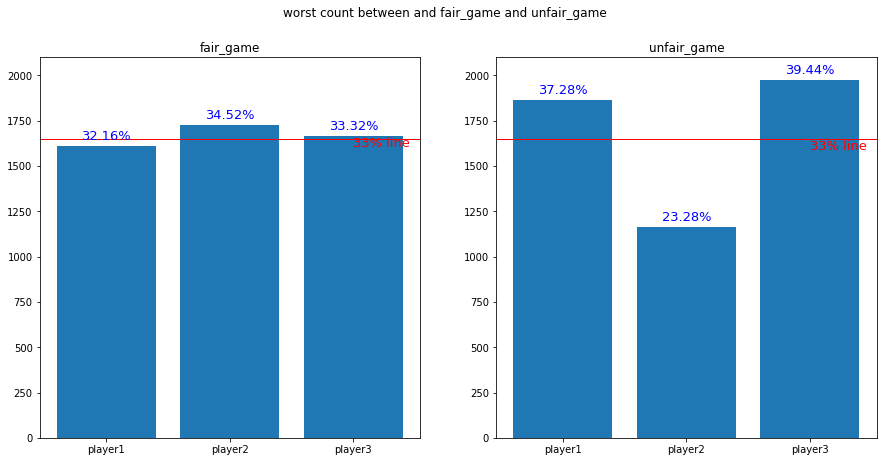

In [5]:
fig = plt.figure(figsize=(15, 7))
fig.suptitle('worst count between and fair_game and unfair_game')
ax1 = fig.add_subplot(121)
ax1.bar(['player1', 'player2', 'player3'], [
    fair_game_result['p1_worst'].sum(),
    fair_game_result['p2_worst'].sum(),
    fair_game_result['p3_worst'].sum()
])
ax1.set_title('fair_game')
ax1.set_ylim([0, 2100])
ax1.axhline([int((fair_game_result.shape[0]) * 0.33)], 0, 1, color="red", linewidth=1)
ax1.annotate("33% line", (2, int((game_result.shape[0]/2) * 0.33) - 100),
    fontsize=13, color='red', xytext=(0, 10),
    textcoords='offset points'
)

ax2 = fig.add_subplot(122)
ax2.bar(['player1', 'player2', 'player3'], [
    unfair_game_result['p1_worst'].sum(),
    unfair_game_result['p2_worst'].sum(),
    unfair_game_result['p3_worst'].sum()
])
ax2.set_title('unfair_game')
ax2.set_ylim([0, 2100])
ax2.axhline([int((unfair_game_result.shape[0]) * 0.33)], 0, 1, color="red", linewidth=1)
ax2.annotate("33% line", (2, int((game_result.shape[0]/2) * 0.33) - 115),
    fontsize=13, color='red', xytext=(0, 10),
    textcoords='offset points'
)

for ax in [ax1, ax2]:
    for p in ax.patches:
        ax.annotate(f"{p.get_height() * 100 / (game_result.shape[0]/2):.2f}%", (p.get_x() + p.get_width() / 2., p.get_height()),
            ha='center', va='center', fontsize=13, color='blue', rotation=0, xytext=(0, 10),
            textcoords='offset points'
        )

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [theta3, theta2, theta1]
Sampling 2 chains: 100%|██████████| 4000/4000 [00:05<00:00, 773.87draws/s]
/opt/conda/lib/python3.6/site-packages/pymc3/plots/__init__.py:40: UserWarning: Keyword argument `varnames` renamed to `var_names`, and will be removed in pymc3 3.8
  warnings.warn('Keyword argument `{old}` renamed to `{new}`, and will be removed in pymc3 3.8'.format(old=old, new=new))
/opt/conda/lib/python3.6/site-packages/pymc3/plots/__init__.py:40: UserWarning: Keyword argument `varnames` renamed to `var_names`, and will be removed in pymc3 3.8
  warnings.warn('Keyword argument `{old}` renamed to `{new}`, and will be removed in pymc3 3.8'.format(old=old, new=new))


,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
theta1,-0.746482,0.030180,0.000546,-0.805443,-0.690560,2810.995227,0.999574
theta2,-0.639848,0.030122,0.000748,-0.697371,-0.579793,1779.360866,0.999518
theta3,-0.694170,0.029398,0.000585,-0.750786,-0.635718,3143.826538,0.999533
player1,0.321624,0.006585,0.000119,0.308863,0.333908,2809.772481,0.999566
player2,0.345313,0.006810,0.000169,0.332395,0.358980,1777.072019,0.999519
player3,0.333138,0.006528,0.000130,0.320650,0.346215,3152.873525,0.999532
diff_player1_player2,-0.023689,0.009364,0.000197,-0.041745,-0.006591,2182.850311,0.999507
diff_player1_player3,-0.011514,0.009099,0.000183,-0.029975,0.005070,3114.295352,0.999503


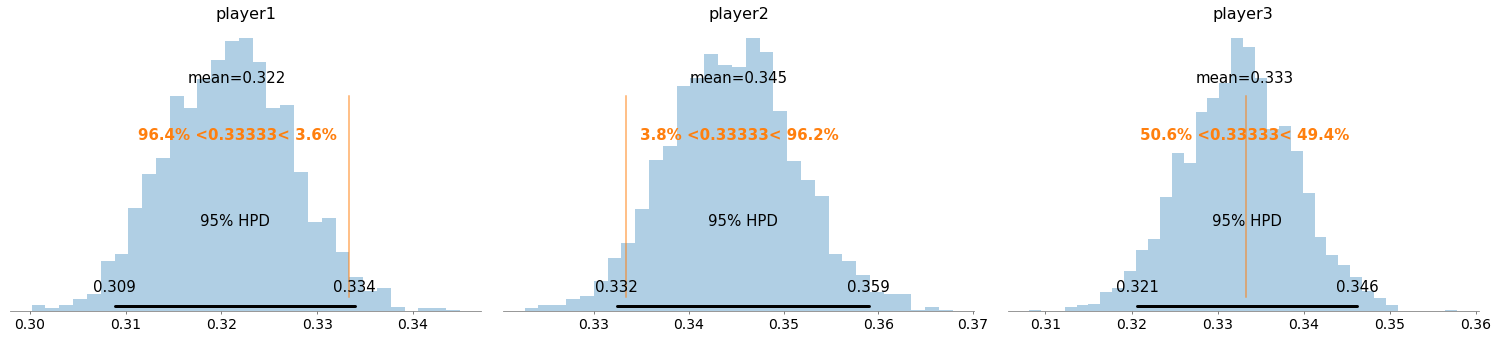

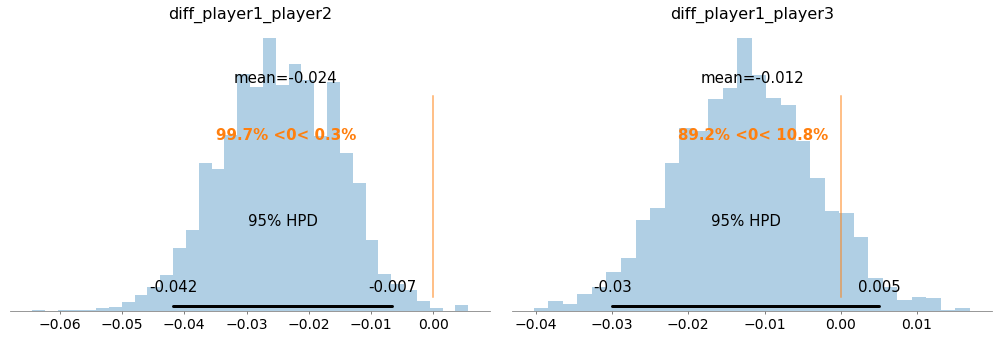

In [6]:
player1_worst = fair_game_result['p1_worst'].values
player2_worst = fair_game_result['p2_worst'].values
player3_worst = fair_game_result['p3_worst'].values

with pm.Model() as model:
        
    theta1 = pm.Normal('theta1', mu=0, sd=100)
    theta2 = pm.Normal('theta2', mu=0, sd=100)
    theta3 = pm.Normal('theta3', mu=0, sd=100)
    p1 = pm.Deterministic('player1', pm.math.sigmoid(theta1))
    p2 = pm.Deterministic('player2', pm.math.sigmoid(theta2))
    p3 = pm.Deterministic('player3', pm.math.sigmoid(theta3))
    diff_p1_p2 = pm.Deterministic('diff_player1_player2', p1 - p2)
    diff_p1_p3 = pm.Deterministic('diff_player1_player3', p1 - p3)
        
    y1 = pm.Bernoulli('y1', p = p1, observed=player1_worst)
    y2 = pm.Bernoulli('y2', p = p2, observed=player2_worst)
    y3 = pm.Bernoulli('y3', p = p3, observed=player3_worst)

with model:
    trace = pm.sample(1500, random_seed=21)[500:]
    
pm.plot_posterior(trace, varnames=['player1','player2','player3'], round_to=3, credible_interval=0.95, kind='hist', ref_val=0.33333)
pm.plot_posterior(trace, varnames=['diff_player1_player2', 'diff_player1_player3'], round_to=3, credible_interval=0.95, kind='hist', ref_val=0)
pm.summary(trace)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [theta2, theta1]
Sampling 2 chains: 100%|██████████| 4000/4000 [00:04<00:00, 954.44draws/s] 
/opt/conda/lib/python3.6/site-packages/pymc3/plots/__init__.py:40: UserWarning: Keyword argument `varnames` renamed to `var_names`, and will be removed in pymc3 3.8
  warnings.warn('Keyword argument `{old}` renamed to `{new}`, and will be removed in pymc3 3.8'.format(old=old, new=new))
/opt/conda/lib/python3.6/site-packages/pymc3/plots/__init__.py:40: UserWarning: Keyword argument `varnames` renamed to `var_names`, and will be removed in pymc3 3.8
  warnings.warn('Keyword argument `{old}` renamed to `{new}`, and will be removed in pymc3 3.8'.format(old=old, new=new))


,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
theta1,-0.639967,0.029673,0.000981,-0.698348,-0.582390,856.711844,1.001161
theta2,-0.553147,0.045463,0.001289,-0.644547,-0.469558,968.770885,1.000077
unfair_probability,0.232758,0.006093,0.000155,0.220066,0.243809,1610.541602,0.999514
fair_probability,0.345285,0.006707,0.000222,0.332179,0.358383,855.931543,1.001142
diff_probability,0.112527,0.009116,0.000266,0.096089,0.131066,916.100377,1.000244


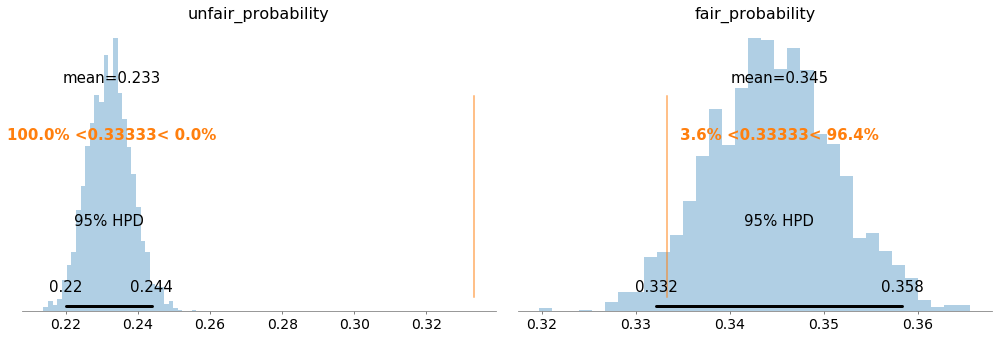

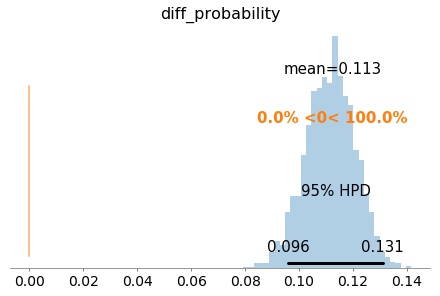

In [7]:
p2_unfair = unfair_game_result['p2_worst'].values
p2_fair = fair_game_result['p2_worst'].values

with pm.Model() as model:
    
    theta1 = pm.Normal('theta1', mu=0, sd=100)
    theta2 = pm.Normal('theta2', mu=0, sd=100)
    unfair_p = pm.Deterministic('unfair_probability', pm.math.sigmoid(theta1 + theta2))
    fair_p = pm.Deterministic('fair_probability', pm.math.sigmoid(theta1))
    diff_p = pm.Deterministic('diff_probability', fair_p - unfair_p)

    y1 = pm.Bernoulli('y1', p = unfair_p, observed=p2_unfair)
    y2 = pm.Bernoulli('y2', p = fair_p, observed=p2_fair)

with model:
    trace = pm.sample(1500, random_seed=21)[500:]

pm.plot_posterior(trace, varnames=['unfair_probability', 'fair_probability'], round_to=3, credible_interval=0.95, kind='hist', ref_val=0.33333)
pm.plot_posterior(trace, varnames=['diff_probability'], round_to=3, credible_interval=0.95, kind='hist', ref_val=0)
pm.summary(trace)